<span style="display: block; background-color: lightgray; padding: 10px; border-bottom: 2px solid blue; color: blue; font-size: 32px;">Install Libraries</span>

In [ ]:
# ! pip install seaborn

In [4]:
# !pip install transformers

In [7]:
# !pip install tensorflow
# !pip install --upgrade pip

In [5]:
# !pip install tqdm

In [9]:
# !pip install nltk

In [10]:
# !pip install textblob

In [ ]:
# !python -m textblob.download_corpora

In [13]:
# !pip install --upgrade tensorflow

<span style="display: block; background-color: lightgray; padding: 10px; border-bottom: 2px solid blue; color: blue; font-size: 32px;">Import Libraries</span>

In [14]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import AutoTokenizer,TFBertModel
from textblob import Word

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-11-12 15:52:39.870078: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-12 15:52:39.870153: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-12 15:52:39.870217: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [15]:
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
# num_tpus_available = len(tf.config.experimental.list_physical_devices('TPU'))
# print("Num TPUs Available: ", num_tpus_available)
# assert num_tpus_available > 0

In [3]:
# num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
# print("Num GPUs Available: ", num_gpus_available)
# assert num_gpus_available > 0

<span style="display: block; background-color: lightgray; padding: 10px; border-bottom: 2px solid blue; color: blue; font-size: 32px;">Load Data</span>

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Colab

In [ ]:
!gdown 1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW
!gdown 1-8TsrqTRFP-q9TM-6HinhO0ZVXFHq9TB
!gdown 1I9aPAvvYgQWdHGKtnd7IeTGXpx8vOm4h

In [ ]:
# Load data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')
map_data = pd.read_csv('title_brand.csv')

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Kaggle

In [16]:
# Load data
train_data = pd.read_csv('/kaggle/input/amazon-comments/train_data.csv', low_memory=False)
test_data = pd.read_csv('/kaggle/input/amazon-comments/test_data.csv')
map_data = pd.read_csv('/kaggle/input/amazon-comments/title_brand.csv')
path='/kaggle/working/'

<span style="display: block; background-color: lightgray; padding: 10px; border-bottom: 2px solid blue; color: blue; font-size: 32px;">Preproccessing</span>

In [5]:
train_data.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime
0,2,NaN,False,2016-11-11,A2OSUEZJIN7BI,0511189877,NaN,Chris,I have an older URC-WR7 remote and thought thi...,Cannot Learn,1478822400
1,5,NaN,True,2016-06-06,A2NETQRG6JHIG7,0511189877,NaN,Qrysta White,First time I've EVER had a remote that needed ...,zero programming needed! Miracle!?,1465171200
2,4,NaN,True,2016-03-10,A12JHGROAX49G7,0511189877,NaN,Linwood,Got them and only 2 of them worked. company ca...,Works Good and programs easy.,1457568000
3,5,NaN,True,2016-01-14,A1KV65E2TMMG6F,0511189877,NaN,Dane Williams,I got tired of the remote being on the wrong s...,Same as TWC remote,1452729600
4,5,NaN,True,2016-10-20,A280POPEWI0NSA,0594459451,NaN,Kristina H.,After purchasing cheap cords from another webs...,Good Quality Cord,1476921600


In [6]:
test_data.head()

,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime
0,NaN,True,2018-06-04,A20GGWE66JW9X2,B006Z394GM,{'Color:': ' FPS01-C'},Brian C Toner,The name and description of this device are mi...,The prize for most useless invention of all ti...,1528070400
1,NaN,True,2018-02-18,ARYJWXHEYHG9M,B005BE058W,"{'Size:': ' 1000W', 'Style:': ' G2'}",Snake,One of the molex connectors on the power suppl...,MELTED MOLEX CONNECTOR,1518912000
2,NaN,True,2018-01-20,A10LHZ7WFZ7HLL,B01DA0YCNC,NaN,Amazon Customer,Remote constantly disconnects/ Roku player fre...,Bricked on the regular,1516406400
3,NaN,True,2018-06-25,A11VN8EOHNLP72,B00FBJ4KYC,NaN,Jeremy Bray,I purchased this 4 year protection plan for a ...,DO NOT BUY!!!,1529884800
4,3.0,True,2016-08-17,A194Y8P8TVT7P9,B00P7G82TS,NaN,Mark,I bought one of these and have regretted it ev...,Nightmare - don't buy,1471392000


In [7]:
null_df = pd.concat([train_data.isna().sum() * 100 / len(train_data) , train_data.isna().sum()], axis=1)
null_df.columns=["percent", "num"]
null_df

,percent,num
overall,0.000000,0
vote,77.177499,647476
verified,0.000000,0
reviewTime,0.000000,0
reviewerID,0.000000,0
asin,0.000000,0
style,41.520173,348331
reviewerName,0.024078,202
reviewText,0.000000,0
summary,0.008940,75


In [8]:
test_data.isna().sum() * 100 / len(test_data) 

vote              75.335
verified           0.000
reviewTime         0.000
reviewerID         0.000
asin               0.000
style             42.480
reviewerName       0.020
reviewText         0.000
summary            0.010
unixReviewTime     0.000
dtype: float64

In [20]:
df_train = train_data.copy()
df_test = test_data.copy()

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Text Cleaning

In [10]:
lemmatizer = WordNetLemmatizer()
def text_cleaning(text):
    # Remove non-alphanumeric characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert multiple whitespace characters to a single space
    text = re.sub(r'\s+', ' ', text)
    # Normalizing Case Folding - Uppercase to Lowercase
    text = text.lower()
    
#     # StopWords
#     sw = stopwords.words('english')
#     text = " ".join(x for x in text.split() if x not in sw)

#     # Remove Rare Words
#     temp_df = pd.Series(' '.join(text).split()).value_counts()
#     drops = temp_df[temp_df <= 1].index
#     text = " ".join(x for x in text.split() if x not in drops)
# #     # Lemmatize
# #     text = " ".join([Word(word).lemmatize() for word in text.split()])
#     text = " ".join(lemmatizer.lemmatize(word) for word in text.split())

    return text

In [21]:
def text_preprocessing(df, dependent_var):
#     lemmatizer = WordNetLemmatizer()
    dataframe = df.copy()
    for i in tqdm(range(3)):
        if i == 0:
            # Remove non-alphanumeric characters and extra whitespace
            dataframe[dependent_var] = dataframe[dependent_var].fillna('').apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
        if i == 1:
            # Convert multiple whitespace characters to a single space
            dataframe[dependent_var] = dataframe[dependent_var].fillna('').apply(lambda x: re.sub(r'\s+', ' ', x))
        if i == 2:
            # Normalizing Case Folding - Uppercase to Lowercase
            dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
#         if i == 3:
#             # StopWords
#             sw = stopwords.words('english')
#             dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
#         if i == 3:
#             # Remove Rare Words
#             temp_df = pd.Series(' '.join(dataframe[dependent_var]).split()).value_counts()
#             drops = temp_df[temp_df <= 1]
#             dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops))
#         if i == 4:
#             # Lemmatize
#             dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
#             dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(lemmatizer.lemmatize(word) for word in x.split()))

    return dataframe

In [22]:
df_train = text_preprocessing(df_train, "reviewText")
df_train = text_preprocessing(df_train, "summary")

100%|██████████| 3/3 [00:09<00:00,  3.04s/it]


In [23]:
df_test = text_preprocessing(df_test, "reviewText")
df_test = text_preprocessing(df_test, "summary")

100%|██████████| 3/3 [00:00<00:00, 12.90it/s]


In [19]:
df_train["reviewText"][8]

'it works i was skeptical about ordering it because the ratings werent great but short of buying a new nook or replacing it with a kindle it was the best shortterm option the original plugin part made a sizzling sound one night and stopped working my husband tried to plug the usb end into one of about usb to plugin wall chargers that we have around the house and none of them worked were assuming there must be some proprietary thing with the nook usb end that wont let you use generic wall chargers which really sucked because he couldnt use his nook for weeks if you are contemplating purchasing a nook it may be something to take into consideration'

In [180]:
df_train['reviewText'] = df_train['reviewText'].apply(text_cleaning)
df_train['summary'] = df_train['summary'].fillna('')
df_train['summary'] = df_train['summary'].apply(text_cleaning)

In [181]:
df_test['reviewText'] = df_test['reviewText'].apply(text_cleaning)
df_test['summary'] = df_test['summary'].fillna('')
df_test['summary'] = df_test['summary'].apply(text_cleaning)

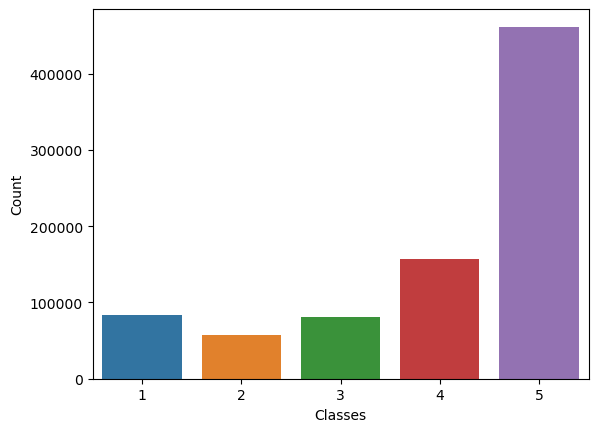

In [20]:
counts = df_train['overall'].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

In [24]:
df_train['review_lengths'] = df_train['reviewText'].apply(len)

In [25]:
df_train['summary_lengths'] = df_train['summary'].apply(len)

In [26]:
df_train['review_lengths'].max()

28429

In [27]:
df_train['summary_lengths'].max()

352

In [28]:
df_train['overall'].value_counts() #/ len(df)

5    461485
4    156514
1     82950
3     81239
2     56756
Name: overall, dtype: int64

In [29]:
df_train[df_train['review_lengths'] < 600]['overall'].value_counts() #/ len(df)

5    339960
4    103230
1     59378
3     54788
2     38393
Name: overall, dtype: int64

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Drop reviewTexts where len(reviewText) > 600 and len(summary) < 100

In [30]:
df_train[(df_train['review_lengths'] > 600) & (df_train['summary_lengths'] < 100)].index

Int64Index([     7,      8,     26,     28,     45,     53,     54,     55,
                56,     58,
            ...
            838908, 838911, 838912, 838914, 838920, 838923, 838929, 838930,
            838933, 838937],
           dtype='int64', length=235054)

In [31]:
drop_indexes = df_train[(df_train['review_lengths'] > 600) & (df_train['summary_lengths'] < 100)].index

In [32]:
df_train = df_train.drop(drop_indexes)

In [33]:
df_train['review_lengths'] = df_train['reviewText'].apply(len)

In [34]:
df_train[(df_train['review_lengths'] > 600) & (df_train['summary_lengths'] < 100)]['overall'].value_counts() #/ len(df)

Series([], Name: overall, dtype: int64)

<span style="display: block; background-color: lightgray; padding: 10px; border-bottom: 2px solid blue; color: blue; font-size: 32px;">Sampling</span>

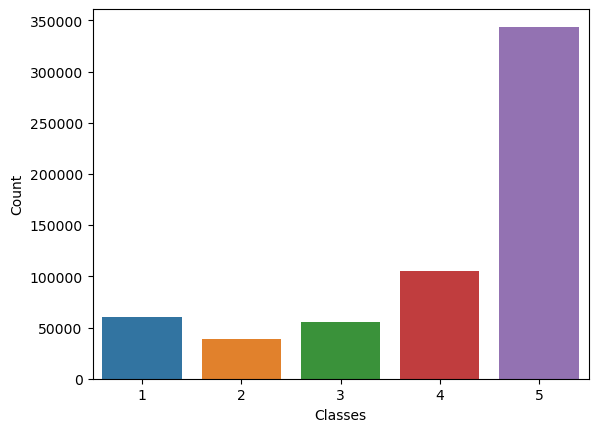

In [32]:
counts = df_train['overall'].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

In [35]:
def sampling(df, num_target, each_class_size):
    # Identify the size of the smallest class
    min_class_size = min(each_class_size, df[num_target].value_counts().min())

    # Perform random sampling for each class to balance the sizes
    balanced_df = pd.concat([
        df[df[num_target] == sentiment].sample(min_class_size, replace=True)
        for sentiment in df[num_target].unique()
    ])

    # Shuffle the rows to randomize the order of samples
    balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
    return balanced_df

In [36]:
df_train_balanced = sampling(df_train, 'overall', 10000)

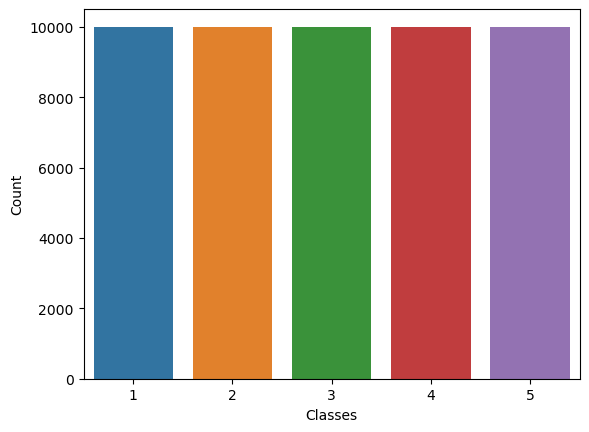

In [37]:
counts = df_train_balanced['overall'].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

<span style="display: block; background-color: lightgray; padding: 10px; border-bottom: 2px solid blue; color: blue; font-size: 32px;">Functions</span>

In [38]:
def save_model(model, tokenizer, filename, path=''):
    save_dir = os.path.join(path, filename)

    # Save tokenizer
    tokenizer.save_pretrained(save_dir +'/Tokenizer')

    # Save model
    model.save_pretrained(save_dir +'/Model')
    print("Saved model to ", save_dir )
    
def load_model(model, tokenizer, filename, path=''):
    load_dir = os.path.join(path, filename)
    
    # Load tokenizer
    tokenizer = tokenizer.from_pretrained(load_dir +'/Tokenizer')

    # Load model
    model = model.from_pretrained(load_dir +'/Model')
    
    return model, tokenizer

In [39]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['balanced_accuracy'])
    plt.plot(history.history['val_balanced_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

In [40]:
def f1_micro(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (actual_positives + K.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1

def f1_micro_onehot(y_true, y_pred):
    y_true = K.cast(K.argmax(y_true, axis=-1), dtype='float32')
    y_pred = K.cast(K.argmax(y_pred, axis=-1), dtype='float32')

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (actual_positives + K.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1

<span style="display: block; background-color: lightgray; padding: 10px; border-bottom: 2px solid blue; color: blue; font-size: 32px;">Split Data</span>

In [41]:
# Training data
Reviews = df_train_balanced['reviewText']
labels = df_train_balanced['overall']
# Test data
test_reviews = df_test['reviewText']

In [70]:
train_reviews, validation_reviews, train_labels, validation_labels = train_test_split(Reviews, labels, test_size=0.3, random_state=42)

<span style="display: block; background-color: lightgray; padding: 10px; border-bottom: 2px solid blue; color: blue; font-size: 32px;">Try Models</span>

<span style="display: block; padding: 1px; border-bottom: 2px solid green; color: green; font-size: 28px;">Model 1</span>

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Tokenize

In [72]:
tokenizer1 = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [73]:
max_len= 128
# Tokenize and encode the sentences
train_encoded = tokenizer1.batch_encode_plus(train_reviews.tolist(),
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')
 
val_encoded = tokenizer1.batch_encode_plus(validation_reviews.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')
 
test_encoded = tokenizer1.batch_encode_plus(test_reviews.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

In [40]:
k = 0
print('Training Comments -->>',Reviews[k])
print('\nInput Ids -->>\n',train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer1.decode(train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',train_encoded['attention_mask'][k])
print('\nLabels -->>',labels[k])


Training Comments -->> this antenna does not transmit on meters mgz it does okay on mgz you are better off with the standard rubber ducky antenna that comes with your standard ht then buying this aftermarket stubby antenna

Input Ids -->>
 tf.Tensor(
[  101  2123  2102  2342  2053 27136  2075 22686  2005  2087  2111  2040
  2079  2025  2444  1999  1037  3541  4044  1996 13438  4742  2515  2025
  2342  2000  2022 26986  6499  2339  3477  2005  2028  2023  2944  2003
  2004  2204  2004  2151 13135  7169 13438  2097  2131  2012  1037  3976
  2896  2084  8990  2035  2500  5959  2334  3703  2005  2489   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0 

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Encode Labels 

In [78]:
train_labels_cat = to_categorical(train_labels - 1)
validation_labels_cat = to_categorical(validation_labels - 1)

In [79]:
train_labels_cat

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Train Model

In [89]:
num_classes = 5

# Intialize the model
model1 = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = CategoricalCrossentropy(from_logits=True)
balanced_accuracy = CategoricalAccuracy('balanced_accuracy')
metric = [balanced_accuracy]
# Compile the model with an appropriate optimizer, loss function, and metrics
model1.compile(optimizer=optimizer, loss=loss, metrics=[metric])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_balanced_accuracy',
                                               min_delta=0,
                                               patience=3,
                                               mode='max',
                                               restore_best_weights=True)

# Train the model
history1 = model1.fit(
    [train_encoded['input_ids'], train_encoded['token_type_ids'], train_encoded['attention_mask']], 
    train_labels_cat,
    validation_data=(
        [val_encoded['input_ids'], val_encoded['token_type_ids'], val_encoded['attention_mask']], 
        validation_labels_cat
    ),
    batch_size=32,
    epochs=10,
    callbacks=[early_stopping]
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
1094/1094 [==============================] - 1104s 970ms/step - loss: 1.1719 - balanced_accuracy: 0.4721 - val_loss: 0.9512 - val_balanced_accuracy: 0.5853
Epoch 2/10
1094/1094 [==============================] - 1056s 965ms/step - loss: 0.8559 - balanced_accuracy: 0.6331 - val_loss: 0.9248 - val_balanced_accuracy: 0.6065
Epoch 3/10
1094/1094 [==============================] - 1055s 965ms/step - loss: 0.6592 - balanced_accuracy: 0.7281 - val_loss: 1.0228 - val_balanced_accuracy: 0.6057
Epoch 4/10
1094/1094 [==============================] - 1056s 965ms/step - loss: 0.4741 - balanced_accuracy: 0.8158 - val_loss: 1.1681 - val_balanced_accuracy: 0.6160
Epoch 5/10
1094/1094 [==============================] - 1054s 963ms/step - loss: 0.3367 - balanced_accuracy: 0.8723 - val_loss: 1.3078 - val_balanced_accuracy: 0.6083
Epoch 6/10
1094/1094 [==============================] - 1056s 965ms/step - loss: 0.2437 - balanced_accuracy: 0.9109 - val_loss: 1.4121 - val_balanced_accuracy: 0.611

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Evaluation on Validation Data

In [210]:
predicted_val = model1.predict([val_encoded['input_ids'], val_encoded['token_type_ids'], val_encoded['attention_mask']])
logits_val = predicted_val.logits
y_val_predicted = tf.argmax(logits_val, axis=1)
y_val_predicted = y_val_predicted.numpy() + 1

y_true = validation_labels
print(f"F1_micro: {f1_score(y_true, y_val_predicted, average='micro')}")

469/469 [==============================] - 132s 281ms/step
F1_micro: 0.616


In [211]:
print("Classification Report: \n", classification_report(y_true, y_val_predicted, labels=list(range(0,6))))

Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.66      0.73      0.70      2990
           2       0.53      0.50      0.51      3059
           3       0.53      0.47      0.50      2954
           4       0.58      0.62      0.60      3009
           5       0.76      0.76      0.76      2988

   micro avg       0.62      0.62      0.62     15000
   macro avg       0.51      0.51      0.51     15000
weighted avg       0.61      0.62      0.61     15000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Plot History

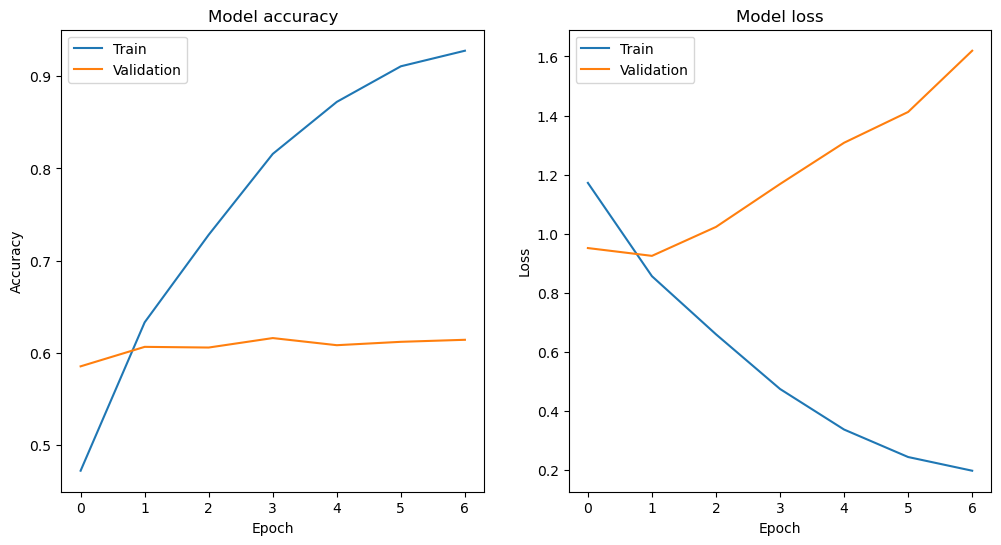

In [212]:
plot_history(history1)

In [213]:
# save model
save_model(model1, tokenizer1,
           filename='Bert_model1', 
           path=path)

Saved model to  /kaggle/working/Bert_model1


<span style="display: block; padding: 1px; border-bottom: 2px solid green; color: green; font-size: 28px;">Model 2</span>

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Tokenize

In [91]:
tokenizer2 = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [129]:
max_len = 128
# Tokenize and encode the sentences
train_encodings = tokenizer2(train_reviews.tolist(),
                            padding=True, 
                            truncation=True,
                            max_length = max_len,
                            return_tensors='tf')
val_encodings = tokenizer2(validation_reviews.tolist(),
                            padding=True, 
                            truncation=True,
                            max_length = max_len,
                            return_tensors='tf')
test_encodings = tokenizer2(test_reviews.tolist(),
                            padding=True, 
                            truncation=True,
                            max_length = max_len,
                            return_tensors='tf')


<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Train Model

In [132]:
num_classes = 5

# Intialize the model
model2 = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=num_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = CategoricalCrossentropy(from_logits=True)
balanced_accuracy = CategoricalAccuracy('balanced_accuracy')
metric = [balanced_accuracy]
# Compile the model with an appropriate optimizer, loss function, and metrics
model2.compile(optimizer=optimizer, loss=loss, metrics=[metric])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_balanced_accuracy',
                                               min_delta=0,
                                               patience=2,
                                               mode='max',
                                               restore_best_weights=True)

# Train the model
batch_size = 32
history2 = model2.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']], 
    train_labels_cat,
    validation_data=(
        [val_encodings['input_ids'], val_encodings['attention_mask']], 
        validation_labels_cat
    ),
    batch_size=32,
    epochs=10,
    callbacks=[early_stopping]
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/10
1094/1094 [==============================] - 520s 455ms/step - loss: 1.0627 - balanced_accuracy: 0.5358 - val_loss: 0.9621 - val_balanced_accuracy: 0.5819
Epoch 2/10
1094/1094 [==============================] - 506s 463ms/step - loss: 0.8405 - balanced_accuracy: 0.6410 - val_loss: 0.9400 - val_balanced_accuracy: 0.6070
Epoch 3/10
1094/1094 [==============================] - 508s 464ms/step - loss: 0.6532 - balanced_accuracy: 0.7306 - val_loss: 1.0241 - val_balanced_accuracy: 0.5991
Epoch 4/10
1094/1094 [==============================] - 507s 464ms/step - loss: 0.4720 - balanced_accuracy: 0.8149 - val_loss: 1.1386 - val_balanced_accuracy: 0.6121
Epoch 5/10
1094/1094 [==============================] - 506s 462ms/step - loss: 0.3346 - balanced_accuracy: 0.8742 - val_loss: 1.3160 - val_balanced_accuracy: 0.6076
Epoch 6/10
1094/1094 [==============================] - 505s 462ms/step - loss: 0.2519 - balanced_accuracy: 0.9070 - val_loss: 1.5105 - val_balanced_accuracy: 0.5984


<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Evaluation on Validation Data

In [214]:
predicted_val = model2.predict([val_encodings['input_ids'], val_encodings['attention_mask']])
logits_val = predicted_val.logits
y_val_predicted = tf.argmax(logits_val, axis=1)
y_val_predicted = y_val_predicted.numpy() + 1

y_true = validation_labels
print(f"F1_micro: {f1_score(y_true, y_val_predicted, average='micro')}")

469/469 [==============================] - 67s 142ms/step
F1_micro: 0.6121333333333333


In [215]:
print("Classification Report: \n", classification_report(y_true, y_val_predicted, labels=list(range(0,6))))

Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.67      0.73      0.70      2990
           2       0.52      0.53      0.52      3059
           3       0.54      0.45      0.49      2954
           4       0.57      0.59      0.58      3009
           5       0.75      0.77      0.76      2988

   micro avg       0.61      0.61      0.61     15000
   macro avg       0.51      0.51      0.51     15000
weighted avg       0.61      0.61      0.61     15000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Plot History

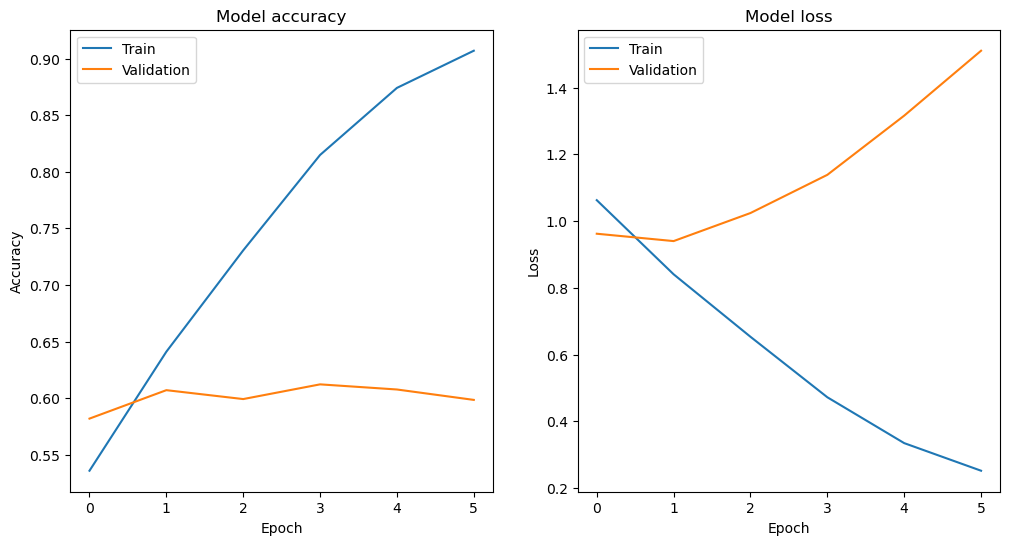

In [216]:
plot_history(history2)

In [217]:
# save model
save_model(model2, tokenizer2,
           filename='Bert_model2', 
           path=path)

Saved model to  /kaggle/working/Bert_model2


<span style="display: block; padding: 1px; border-bottom: 2px solid green; color: green; font-size: 28px;">Model 3</span>

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Prepare Data

In [42]:
train_reviews, validation_reviews, train_labels, validation_labels = train_test_split(Reviews, labels, test_size=0.3, random_state=42)

In [43]:
df_train_val_balanced = df_train_balanced.copy()

In [44]:
df_train_val_balanced = df_train_balanced[['reviewText', 'overall']]
df_train_val_balanced.columns = ['Input', 'Sentiment']
df_train_val_balanced.head()

,Input,Sentiment
0,i use this and a spray bottle full of distille...,4
1,i take it backafter just over a month mine are...,1
2,i bought a total of of these guys for my daugh...,1
3,much better than the old ones the f i ur i bou...,4
4,this thing is super low quality you can hear t...,1


In [45]:
X_train, X_validation, y_train, y_validation = train_test_split(df_train_val_balanced[['Input']], df_train_val_balanced['Sentiment'], random_state=42)

In [46]:
df_test2 = df_test[['reviewText']]
df_test2.columns = ['Input']
df_test2.head()

,Input
0,the name and description of this device are mi...
1,one of the molex connectors on the power suppl...
2,remote constantly disconnects roku player free...
3,i purchased this year protection plan for a se...
4,i bought one of these and have regretted it ev...


<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Encode Label

In [47]:
y_train_cat = to_categorical(y_train - 1)
y_validation_cat = to_categorical(y_validation - 1)

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Tokenize

In [48]:
tokenizer3 = BertTokenizer.from_pretrained('bert-base-uncased')

In [49]:
max_len = 128

x_train = tokenizer3(
    text=X_train.Input.tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

x_validation = tokenizer3(
    text=X_validation.Input.tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

x_test = tokenizer3(
    text=df_test2.Input.tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Train Model

In [ ]:
num_classes = 5

bert = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

max_len = 128

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.Flatten()(embeddings)
out = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(out)
out = tf.keras.layers.Dropout(0.2)(out)
out = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(out)
y = Dense(5,activation = 'softmax')(out)

model3 = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model3.layers[2].trainable = True
model3.summary()

optimizer = Adam(learning_rate=5e-05, epsilon=1e-08, clipnorm=1.0)
# Set loss and metrics
loss = CategoricalCrossentropy(from_logits = True)
balanced_accuracy = CategoricalAccuracy('balanced_accuracy')
metric = [balanced_accuracy]
# Compile the model
model3.compile(optimizer=optimizer, loss=loss, metrics=metric)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_balanced_accuracy',
                                               min_delta=0,
                                               patience=2,
                                               mode='max',
                                               restore_best_weights=True)

history3 = model3.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train_cat,
    validation_data = (
    {'input_ids':x_validation['input_ids'],'attention_mask':x_validation['attention_mask']},
        y_validation_cat
    ),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Evaluation on Validation Data

In [ ]:
predicted_val = model3.predict([val_encodings['input_ids'], val_encodings['attention_mask']])
logits_val = predicted_val.logits
y_val_predicted = tf.argmax(logits, axis=1)
y_val_predicted = y_val_predicted.numpy() + 1

y_true = validation_labels
print(f"F1_micro: {f1_score(y_true, y_val_predicted, average='micro')}")

In [ ]:
# save model
save_model(model3, tokenizer3,
           filename='Bert_model3', 
           path=path)

<span style="display: block; background-color: lightgray; padding: 10px; border-bottom: 2px solid blue; color: blue; font-size: 32px;">Test on best Model (Model 1)</span>

In [227]:
predicted_test = model1.predict([test_encoded['input_ids'], test_encoded['attention_mask']])
logits_test = predicted_test.logits

y_test_predicted = tf.argmax(logits_test, axis=1)
y_test_predicted = y_test_predicted.numpy() + 1

625/625 [==============================] - 176s 282ms/step


In [228]:
df = pd.DataFrame({'predicted': y_test_predicted})

df.to_csv('/kaggle/working/q2_submission.csv', index=False)
df.head()

,predicted
0,1
1,2
2,2
3,1
4,1
